<a href="https://colab.research.google.com/github/SteinwayThor/eeg-features-movies/blob/main/happy_not_happy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
# generic torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

# generic ml/stats imports
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.fftpack as sp
from sklearn.model_selection import train_test_split
from math import pi
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

#torch vision related imports
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

# data utils
import time
import os
import pickle
import json
from PIL import Image
from google.colab import drive
import bz2
import _pickle as cPickle
import pickle as pl
from scipy.io import loadmat
import gc
from collections import Counter

In [2]:
drive.mount('/content/drive', force_remount=True)

# Load any compressed pickle file
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

Mounted at /content/drive


In [3]:
frames_data_folder = '/content/drive/MyDrive/GreenBookAnnotations/greenbook/data'

import csv

with open(os.path.join(frames_data_folder, 'sync_happy_complete.csv'), newline='') as csvfile:
    labels = pd.read_csv(csvfile)

#frames_dict = {'chapters': data[1:, 0], 'sample_num': data[1:, 1], 'emotion': data[1:, 2]}

In [5]:
Counter(labels.emotion)

Counter({nan: 8941, 'not_happy': 8924, 'happy': 1129})

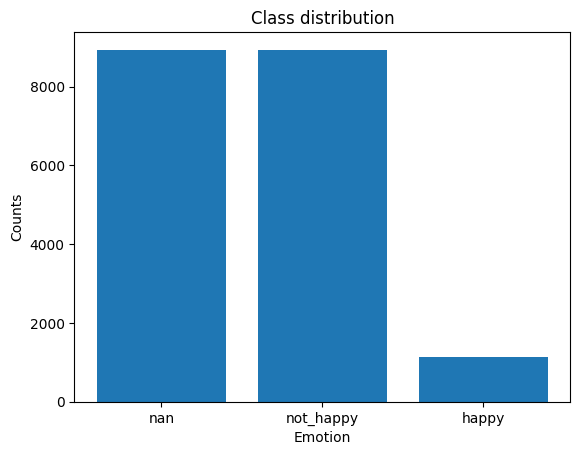

In [10]:
plt.figure()
class_counts = {'nan': 8941, 'not_happy': 8924, 'happy': 1129}
plt.bar(x = [0,1,2], height = list(class_counts.values()))
plt.xticks(ticks = range(3), labels=list(class_counts.keys()))
plt.xlabel("Emotion")
plt.ylabel("Counts")
plt.title("Class distribution")
plt.show()

In [9]:
spectrograms_folder = '/content/drive/MyDrive/spectrograms'
npy_files = os.listdir(spectrograms_folder)

# spectrograms = {}
X = []
Y = []
for idx, f in enumerate(npy_files[:-1]):
  print(idx)
  raw = np.mean(np.load(os.path.join(spectrograms_folder, f)), axis=1)  #samples, 129,5
  gc.collect()
  #extract samples which have a label for them
  idx_emotion = labels[(labels.chapters==idx+1) & (~labels.emotion.isna())].sample_num
  X.extend(raw[idx_emotion])
  Y.extend(labels[(labels.chapters==idx+1) & (~labels.emotion.isna())].emotion)
  del raw, idx_emotion
  gc.collect()

print(len(X), len(Y))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
10053 10053


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7037, 3016, 7037, 3016)

In [17]:
np.save('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/x_train.npy',np.array(X_train))
np.save('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/y_train.npy',np.array(y_train))
np.save('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/x_test.npy',np.array(X_test))
np.save('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/y_test.npy',np.array(y_test))

In [8]:
try:
  del X_train, X_test, y_train, y_test
except:
  pass
gc.collect()

8

In [9]:
X_train = np.load('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/x_train.npy')
X_test = np.load('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/x_test.npy')
y_train = np.load('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/GreenBookAnnotations/greenbook/data/y_test.npy')

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7037, 129, 5), (3016, 129, 5), (7037,), (3016,))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# loads the network and sends it to the device (vgg19)
model = models.vgg19(weights="IMAGENET1K_V1").to(device)
# sets model to eval mode
model.eval()

Running on cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def decode_preds(outputs, class_names=['happy', 'not_happy']):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)
  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()
  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
    print(f'\nClass: {label}, Probability: {score}')

In [4]:
gc.collect()

30

In [ ]:
#7039, 3, 224, 224
result_shape = (7039, 3, 224, 224)
X_train_processed = torch.empty(result_shape, dtype=torch.float32)
for pos,img in enumerate(X_train):
    img = cv2.resize(img, (224, 224))
    img = torch.tensor(np.array([img for i in range(3)]))
    X_train_processed[pos] = img
    print(pos+1)
gc.collect()
#X_train_processed_torch = torch.stack(X_train_processed)
del X_train, img
gc.collect()


In [12]:
X_train_processed.shape

torch.Size([7039, 3, 224, 224])

In [13]:
X_test.shape

(3016, 129, 5)

In [ ]:
#3016, 3, 224, 224
result_shape = (3016, 3, 224, 224)
X_test_processed = torch.empty(result_shape, dtype=torch.float32)
for pos,img in enumerate(X_test):
    img = cv2.resize(img, (224, 224))
    img = torch.tensor(np.array([img for i in range(3)]))
    X_test_processed[pos] = img
    print(pos+1)
gc.collect()
#X_train_processed_torch = torch.stack(X_train_processed)
del X_test, img
gc.collect()

In [16]:
X_test_processed.shape

torch.Size([3016, 3, 224, 224])

In [19]:
np.unique(y_train)

array(['happy', 'not_happy'], dtype='<U9')

In [20]:
def conv_to_num(x):
  if x=='happy':
    return 0
  else:
    return 1

In [21]:
y_train = [conv_to_num(x) for x in y_train]
y_test = [conv_to_num(x) for x in y_test]

In [23]:
#happy as 0, not_happy as 1
num_classes = 2

# One-hot encode the labels using PyTorch
y_train = torch.eye(num_classes)[y_train]
y_test = torch.eye(num_classes)[y_test]
# Convert the one-hot encoded matrix to a PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


<ipython-input-23-7261ed4ec416>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-23-7261ed4ec416>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# # Load the pre-trained VGG19 model
standard_vgg19 = models.vgg19(weights="IMAGENET1K_V1").to(device)

# # Freeze the layers of the standard VGG19
for param in standard_vgg19.parameters():
  param.requires_grad = False

# # Modify the model for 11-class classification of EEG images
# # Remove the fully connected layers (classifier) on top
standard_vgg19.classifier = nn.Identity()

# # Now create a new model with the features of the standard VGG19 and a new classifier
class NewVGG19(nn.Module):
  def __init__(self):
    super(NewVGG19, self).__init__()
    self.features = standard_vgg19.features
    self.avgpool = standard_vgg19.avgpool
    self.oldvgg = standard_vgg19
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512 * 7 * 7, 2), # Assuming the output size is 512*7*7,adjust if necessary
      nn.Softmax(dim=1)
    )
  def forward(self, x):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.oldvgg(x)
    x = self.classifier(x)
    return x
# # --------------------- #
model = NewVGG19().to(device)
# Print the summary of the new model
print(model)


Running on cuda:0
NewVGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 

In [45]:
X_train_processed.size(), y_train.size()

(torch.Size([7037, 3, 224, 224]), torch.Size([7037, 2]))

In [46]:
train = data_utils.TensorDataset(X_train_processed, y_train)
train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)

test = data_utils.TensorDataset(X_test_processed, y_test)
testing_loader = data_utils.DataLoader(test, batch_size=50, shuffle=True)

In [47]:
#X_train_processed, X_test_processed, y_train, y_test
# # train the network

# # Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Define training parameters
epochs = 5
val_accuracies = []
test_accuracies = []
 # Training loop
model = model.cuda()
for epoch in range(epochs):
  total_loss = 0
  model.train()
  for (batch_X, batch_y) in train_loader:
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(batch_X.cuda())

    # Compute the loss
    loss = criterion(outputs, batch_y.cuda())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    total_loss += loss.item()
  # Print average loss for the epoch
  print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

  model.eval()




Epoch 1, Loss: 0.4235
Epoch 2, Loss: 0.4235
Epoch 3, Loss: 0.4233
Epoch 4, Loss: 0.4234
Epoch 5, Loss: 0.4233


RuntimeError: ignored

In [99]:
test_acc = []
for (batch_X, batch_y) in testing_loader:
  # print(torch.argmax(batch_y))
  # Forward pass
  test_outputs = model(batch_X.cuda())
    # Compute the loss
  test_loss = criterion(test_outputs, batch_y.cuda())
    # If y_val is one-hot encoded
  _, test_preds = torch.max(test_outputs, 1)
  # print(test_preds)
    # accuracy = calculate_acc(outputs, batch_y)
  test_loss += loss.item()
  # val_acc += accuracy.item()
  # _, yv = torch.max(batch_y, 1)
  test_acc.append((test_preds == torch.argmax(batch_y.cuda(), dim=1)).float().mean().item())
test_accuracies.append(np.mean(test_acc))
print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {np.mean(test_acc):.4f}")


Test Loss: 0.8056, Test Accuracy: 0.8825


In [58]:
8924/(8924+1129)

0.8876952153585994

In [70]:
idx = np.random.randint(0,X_test_processed.shape[0], size=200)

In [82]:
y_pred = model(X_test_processed[idx].cuda())
_, y_pred = torch.max(y_pred, 1)

In [103]:
print(classification_report(torch.argmax(y_test[idx], dim=1).cpu().numpy(), y_pred.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.89      1.00      0.94       177

    accuracy                           0.89       200
   macro avg       0.44      0.50      0.47       200
weighted avg       0.78      0.89      0.83       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
